# Solving Full Cell Simulation Using the Discontinuous Galerkin Method with Interior Penalty
Author: E Leshinka Molel

In this notebook we set to solve the full cell simulation equations for a solid-state battery. The full-cell is simplified to include three domains
- negative electrode
- solid electrolyte (SE) separator
- positive electrode

At the interface between negative electrode and SE, and the interface between SE and positive electrode, we have charge transfer reactions. For simplicity, linear kinetics are assumed.

Phase 1 is the solid active material and phase 2 is the SE.

Current flowing due to charge transfer reaction is given by linear kinetics expression:
$$i = \frac{F i_{o}}{RT}(\phi_1 - \phi_2 - U)$$

The above expression can be written twice, once for -ve electrode and once for +ve electrode.

In our case, for simplicity, infinite kinetics are assumed at the negative electrode and SE separator.

## Setting Up Variational Formulation
$$\nabla \cdot (-\kappa \nabla u) = f$$
$$u(x=0,y) = u_0$$
$$u(x=L_x,y) = u_{L_x}$$
$$-\kappa \nabla u \cdot \hat{n}|_{y=0,y=L_y} = 0$$

The total domain is indicated by $\Omega$ and the external boundary of the domain by $\partial \Omega$.

Because of the internal discontinuity in $u$, we use Discontinuous Lagrange elements. We solve the partial differential equation for each element $K_i$ then sum over all the $N$ elements. This involves multiplying by a test function $v$ and integrating over the element $K_i$.

$$\sum_i^N \int_{K_i} -\nabla \cdot(\kappa u_i) v \mathrm{dx} = \sum_i^N \int_{K_i} f_i v_i \mathrm{dx}$$
Integrating the LHS by parts, we obtain:
$$\sum_i^N \int_{K_i} -\kappa \nabla u_i \cdot \nabla v_i \mathrm{dx} + \sum_i^N \int_{\partial K_i} \kappa \hat{n_i} \cdot \nabla u_i \cdot v_i \mathrm{ds} = \sum_i^N \int_{K_i} f_i v_i \mathrm{dx}$$

We can split the second term on the LHS to have the parts of the external boundary: $\bigcup \partial \Omega_i = \partial \Omega$ for $i=1,...,N$. Also $\partial \Omega_i \bigcup \partial \hat{K_i} = \partial K_i$.

Therefore, we have:
$$\int_{\Omega} -\kappa \nabla u \cdot \nabla v \mathrm{dx} + \int_{\partial \Omega} \kappa \hat{n} \cdot \nabla u \cdot v \mathrm{ds} + \sum_i^N \int_{\partial \hat{K_i}} \kappa \hat{n_i} \cdot \nabla u_i \cdot v_i \mathrm{ds} = \int_{\Omega} f v \mathrm{dx}$$

The second term on the LHS can be used to set the Neumann boundary conditions where we have those. Below, we expound further on the third term on the LHS.

We note that for the third term, we have an integral for each side of the integral facet, say between cell $i$ and $j$. We can therefore write this integral as a jump integral (noting that $n_i=-n_j$) over the set of all internal facets $E_j, j=0,\dots,N_{internal}$

\begin{align}
\sum_i^N \int_{\partial \hat{K_i}} \kappa \hat{n_i} \cdot \nabla u_i \cdot v_i \mathrm{ds} = -\sum_j^{N_{internal}} \int_{E_j} \kappa \hat{n_j} \cdot [\nabla u_j \cdot v_j] \mathrm{ds}
\end{align}

We can further expand the RHS of above using the relation $[a \cdot b] = \langle a\rangle \cdot [b] + [a] \cdot \langle b \rangle$. Where $\langle \text{value} \rangle$ denotes average of the value across the shared internal boundary. Therefore, we can rewrite our expression above into:

\begin{align}
\sum_i^N \int_{\partial \hat{K_i}} \kappa \hat{n_i} \cdot \nabla u_i \cdot v_i \mathrm{ds} = -\sum_j^{N_{internal}} \int_{E_j} \kappa \hat{n_j} \cdot [\nabla u_j] \cdot \langle v_j\rangle \mathrm{ds} -\sum_j^{N_{internal}} \int_{E_j} \kappa \hat{n_j} \cdot \langle \nabla u_j\rangle \cdot [v_j] \mathrm{ds}
\end{align}

Because we want our solution to be conservative, we enforce that the jump of the gradient in normal direction is zero by removing the term involving $[\nabla u]$ from the RHS of the above expression.

To maintain symmetry when $u$ and $v$ are switched, we add a term $-\sum_j^{N_{internal}} \int_{E_j} \kappa \hat{n_j} \cdot \langle \nabla v_j\rangle \cdot [u_j] \mathrm{ds}$ to the RHS. We also add another term to the RHS for coercivity: $\int_{E_j}\frac{\gamma}{\langle h \rangle}[u][v]~\mathrm{d}s$ where $h$ is the diameter of the circumscribed circle.

We use Nitsche's method to impose Dirichlet and Neumann boundary conditions on the exterior boundary $\partial \Omega$.

In [1]:
import os

import dolfinx
import gmsh
import matplotlib.pyplot as plt
import meshio
import numpy as np
import ufl
import warnings

from basix.ufl import element
from dolfinx import cpp, default_scalar_type, fem, graph, io, mesh, nls, plot
from dolfinx.fem import petsc
from dolfinx.graph import partitioner_parmetis
from dolfinx.io import gmshio, VTXWriter
from dolfinx.nls import petsc as petsc_nls
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from mpi4py import MPI
from petsc4py import PETSc
from ufl import (Circumradius, FacetNormal, SpatialCoordinate, TrialFunction, TestFunction,
                 dot, div, dx, ds, dS, grad, inner, grad, avg, jump)

import commons, geometry, utils

warnings.simplefilter('ignore')

In [2]:
!rm -r ~/.cache/fenics

In [3]:
Wa = 1e3
encoding = io.XDMFFile.Encoding.HDF5
comm = MPI.COMM_WORLD
micron = 1e-6
markers = commons.Markers()
LX = 150 * micron
LY = 40 * micron

# workdir = "output/subdomains_dg/150-40-0/20-55-20/1e-07/"
workdir = "output/tertiary_current/150-40-0/20-55-20/5.0e-06/"
utils.make_dir_if_missing(workdir)
output_meshfile = os.path.join(workdir, 'mesh.msh')
potential_resultsfile = os.path.join(workdir, "potential.bp")
concentration_resultsfile = os.path.join(workdir, "concentration.bp")
current_resultsfile = os.path.join(workdir, "current.bp")

R = 8.3145
T = 298
faraday_const = 96485
kappa_elec = 0.1
kappa_pos_am = 0.2
i0_p = kappa_elec * R * T / faraday_const / Wa / LX

def ocv(sod, L=1, k=2):
    return 2.5 + (1/k) * np.log((L - sod) / sod)

u_ocv = ocv(0.975)
u_ocv = 0

In [4]:
partitioner = mesh.create_cell_partitioner(mesh.GhostMode.shared_facet)
domain, ct, ft = gmshio.read_from_msh(output_meshfile, comm, partitioner=partitioner)

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, fdim)

ft_imap = domain.topology.index_map(fdim)
num_facets = ft_imap.size_local + ft_imap.num_ghosts
indices = np.arange(0, num_facets)
values = np.zeros(indices.shape, dtype=np.intc)  # all facets are tagged with zero

values[ft.indices] = ft.values
ft = mesh.meshtags(domain, fdim, indices, values)

dx = ufl.Measure("dx", domain=domain, subdomain_data=ct)
ds = ufl.Measure("ds", domain=domain, subdomain_data=ft)
f_to_c = domain.topology.connectivity(fdim, tdim)
c_to_f = domain.topology.connectivity(tdim, fdim)
charge_xfer_facets = ft.find(markers.electrolyte_v_positive_am)

interface_facets = []
for f in charge_xfer_facets:
    if f >= ft_imap.size_local or len(f_to_c.links(f)) != 2:
        continue
    c_0, c_1 = f_to_c.links(f)[0], f_to_c.links(f)[1]
    subdomain_0, subdomain_1 = ct.values[[c_0, c_1]]
    local_f_0 = np.where(c_to_f.links(c_0) == f)[0][0]
    local_f_1 = np.where(c_to_f.links(c_1) == f)[0][0]
    if subdomain_0 > subdomain_1:
        interface_facets.append(c_0)
        interface_facets.append(local_f_0)
        interface_facets.append(c_1)
        interface_facets.append(local_f_1)
    else:
        interface_facets.append(c_1)
        interface_facets.append(local_f_1)
        interface_facets.append(c_0)
        interface_facets.append(local_f_0)
dS = ufl.Measure("dS", domain=domain, subdomain_data=[(markers.electrolyte_v_positive_am, interface_facets)])

Info    : Reading 'output/tertiary_current/150-40-0/20-55-20/5.0e-06/mesh.msh'...
Info    : 77 entities
Info    : 3576 nodes
Info    : 7320 elements
Info    : Done reading 'output/tertiary_current/150-40-0/20-55-20/5.0e-06/mesh.msh'


In [5]:
submesh, entity_map, vertex_map, geom_map = dolfinx.mesh.create_submesh(domain, tdim, ct.find(markers.positive_am))

# Transfer facet tags from parent mesh to submesh
c_to_f = domain.topology.connectivity(tdim, fdim)
f_map = domain.topology.index_map(fdim)
all_facets = f_map.size_local + f_map.num_ghosts
all_values = np.zeros(all_facets, dtype=np.int32)
all_values[ft.indices] = ft.values

submesh.topology.create_entities(fdim)
subf_map = submesh.topology.index_map(fdim)
submesh.topology.create_connectivity(tdim, fdim)
c_to_f_sub = submesh.topology.connectivity(tdim, fdim)
num_sub_facets = subf_map.size_local + subf_map.num_ghosts
sub_values = np.empty(num_sub_facets, dtype=np.int32)
for i, entity in enumerate(entity_map):
    parent_facets = c_to_f.links(entity)
    child_facets = c_to_f_sub.links(i)
    for child, parent in zip(child_facets, parent_facets):
        sub_values[child] = all_values[parent]
submesh_ft = dolfinx.mesh.meshtags(submesh, submesh.topology.dim - 1, np.arange(
    num_sub_facets, dtype=np.int32), sub_values)
submesh.topology.create_connectivity(submesh.topology.dim - 1, submesh.topology.dim)

dx_r = ufl.Measure("dx", domain=submesh)
ds_r = ufl.Measure("ds", domain=submesh, subdomain_data=submesh_ft)
dS_r = ufl.Measure("dS", domain=submesh, subdomain_data=submesh_ft)

In [6]:
nmc_622_density = 2.597e3
area_electrolyte = fem.assemble_scalar(fem.form(1.0 * dx(markers.electrolyte)))
area_positive_am = fem.assemble_scalar(fem.form(1.0 * dx(markers.positive_am)))
print(f"Electrolyte Area: {area_electrolyte:.2e}")
print(f"Positive AM Area: {area_positive_am:.2e}")
# assume 1 meter
positive_capacity = utils.nmc_capacity(nmc_622_density, area_positive_am * 1)
print(f"Positive Capacity: {positive_capacity * 1000:.3f} [mA.h]")
c_li = utils.lithium_concentration_nmc(nmc_622_density)
print(f"Lithium concentration in NMC622: {c_li} [mol/m3]")

Electrolyte Area: 3.70e-09
Positive AM Area: 1.70e-09
Positive Capacity: 1.221 [mA.h]
Lithium concentration in NMC622: 26793.083525916143 [mol/m3]


### Function Spaces

In [7]:
V = fem.functionspace(domain, ("DG", 1))
V_CG = fem.functionspace(domain, ("CG", 1))
V2 = fem.functionspace(domain, ("DG", 1, (3,)))
Q = fem.functionspace(domain, ("DG", 0))
u = fem.Function(V, name='potential', dtype=np.float64)
u_cg = fem.Function(V_CG, name='potential', dtype=np.float64)
v = ufl.TestFunction(V)
n = ufl.FacetNormal(domain)
x = ufl.SpatialCoordinate(domain)

h = ufl.CellDiameter(domain)
h_avg = avg(h)

In [8]:
f = fem.Constant(domain, PETSc.ScalarType(0))
g = fem.Constant(domain, PETSc.ScalarType(0))
voltage = 2
u_left = fem.Function(V)
with u_left.vector.localForm() as u0_loc:
    u0_loc.set(0)
u_right = fem.Function(V)
with u_right.vector.localForm() as u1_loc:
    u1_loc.set(voltage)

In [9]:
def arctanh(y):
    return 0.5 * ufl.ln((1 + y) / (1 - y))


def ocv(c, cmax=c_li):
    xi = 2 * (c - 0.5 * cmax) / cmax
    return 3.25 - 0.5 * arctanh(xi)

In [10]:
c_init = 1000#0.5 * c_li  # mol/m3
t = 0 # Start time
eps = 1e-8
dt = 1e-4
T = 50 * dt
D_bulk = 1e-15
D = fem.Constant(submesh, D_bulk)

nc = ufl.FacetNormal(submesh)
W = fem.functionspace(submesh, ("CG", 1))
c_n = fem.Function(W, dtype=np.float64)
c_n.name = "c_n"
c_n.interpolate(lambda x:  x[0] - x[0] + c_init)
c_n.x.scatter_forward()

potential = fem.Function(W, dtype=np.float64)
padding = 1e-14
u1_2_u2_nmm_data = fem.create_nonmatching_meshes_interpolation_data(
            potential.function_space.mesh,
            potential.function_space.element,
            u.function_space.mesh, padding=padding)

potential.interpolate(u, nmm_interpolation_data=u1_2_u2_nmm_data)
potential.x.scatter_forward()

ch = fem.Function(W, dtype=np.float64)
ch.name = "concentration"
ch.interpolate(lambda x: x[0] - x[0] + c_init)
ch.x.scatter_forward()

c = ufl.TrialFunction(W)
q = ufl.TestFunction(W)

fc = fem.Constant(submesh, PETSc.ScalarType(0))
gc = fem.Constant(submesh, PETSc.ScalarType(0))
g_middle = fem.Constant(submesh, PETSc.ScalarType(0))

cp = fem.Function(V)

u2_2_u1_nmm_data = fem.create_nonmatching_meshes_interpolation_data(
            cp.function_space.mesh,
            cp.function_space.element,
            ch.function_space.mesh, padding=padding)
cp.interpolate(ch, nmm_interpolation_data=u2_2_u1_nmm_data)
cp.x.scatter_forward()

#### $\kappa$ varying in each domain

In [11]:
kappa = fem.Function(Q)
cells_electrolyte = ct.find(markers.electrolyte)
cells_pos_am = ct.find(markers.positive_am)
kappa.x.array[cells_electrolyte] = np.full_like(cells_electrolyte, kappa_elec, dtype=default_scalar_type)
kappa.x.array[cells_pos_am] = np.full_like(cells_pos_am, kappa_pos_am, dtype=default_scalar_type)

### variational formulation

In [12]:
alpha = 100
gamma = 100

i_loc = -inner((kappa * grad(u))('+'), n("+"))
u_jump = 2 * ufl.ln(0.5 * i_loc/i0_p + ufl.sqrt((0.5 * i_loc/i0_p)**2 + 1)) * (R * T / faraday_const)

F = kappa * inner(grad(u), grad(v)) * dx - f * v * dx - kappa * inner(grad(u), n) * v * ds

# Add DG/IP terms
F += - avg(kappa) * inner(jump(u, n), avg(grad(v))) * dS
F += - inner(avg(kappa * grad(u)), jump(v, n)) * dS
F += alpha / h_avg * avg(kappa) * inner(jump(v, n), jump(u, n)) * dS

# Internal boundary
F += + avg(kappa) * dot(avg(grad(v)), (u_jump + ocv(cp("+"))) * n('+')) * dS(markers.electrolyte_v_positive_am)
F += -alpha / h_avg * avg(kappa) * dot(jump(v, n), (u_jump + ocv(cp("+"))) * n('+')) * dS(markers.electrolyte_v_positive_am)

# # Symmetry
F += - avg(kappa) * inner(jump(u, n), avg(grad(v))) * dS(markers.electrolyte_v_positive_am)

# # Coercivity
F += alpha / h_avg * avg(kappa) * inner(jump(u, n), jump(v, n)) * dS(markers.electrolyte_v_positive_am)

# Nitsche Dirichlet BC terms on left and right boundaries
F += - kappa * (u - u_left) * inner(n, grad(v)) * ds(markers.left)
F += -gamma / h * (u - u_left) * v * ds(markers.left)
F += - kappa * (u - u_right) * inner(n, grad(v)) * ds(markers.right) 
F += -gamma / h * (u - u_right) * v * ds(markers.right)

# Nitsche Neumann BC terms on insulated boundary
F += -g * v * ds(markers.insulated_electrolyte) + gamma * h * g * inner(grad(v), n) * ds(markers.insulated_electrolyte)
F += - gamma * h * inner(inner(grad(u), n), inner(grad(v), n)) * ds(markers.insulated_electrolyte)
F += -g * v * ds(markers.insulated_positive_am) + gamma * h * g * inner(grad(v), n) * ds(markers.insulated_positive_am)
F += - gamma * h * inner(inner(grad(u), n), inner(grad(v), n)) * ds(markers.insulated_positive_am)

### variational problem solution

In [13]:
problem = petsc.NonlinearProblem(F, u)
solver = petsc_nls.NewtonSolver(comm, problem)
solver.convergence_criterion = "residual"
solver.maximum_iterations = 25
# solver.atol = 1e-12
# solver.rtol = 1e-11

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
ksp.setFromOptions()
n_iters, converged = solver.solve(u)
if not converged:
    print(f"Not converged in {n_iters} iterations")
else:
    print(f"Converged in {n_iters} iterations")

u_cg.interpolate(u)
with VTXWriter(comm, potential_resultsfile, [u], engine="BP4") as vtx:
    vtx.write(0.0)

current_expr = fem.Expression(-kappa * grad(u), V2.element.interpolation_points())
current_h = fem.Function(V2, name='current_density')
current_h.interpolate(current_expr)

with VTXWriter(comm, current_resultsfile, [current_h], engine="BP4") as vtx:
    vtx.write(0.0)

# results summary
I_left = fem.assemble_scalar(fem.form(inner(current_h, n) * ds(markers.left)))
I_right = fem.assemble_scalar(fem.form(inner(current_h, n) * ds(markers.right)))
I_interface = fem.assemble_scalar(fem.form(inner(current_h("-"), n("-")) * dS(markers.electrolyte_v_positive_am)))
area_pos_xfer = fem.assemble_scalar(fem.form(1.0 * dS(markers.electrolyte_v_positive_am)))
eta_pos = fem.assemble_scalar(fem.form((u("+") - u("-") - u_ocv) * dS(markers.electrolyte_v_positive_am))) / area_pos_xfer
I_pos_charge_transfer = eta_pos * i0_p * faraday_const / (R * T) * area_pos_xfer
I_insulated_sse = fem.assemble_scalar(fem.form(np.abs(inner(current_h, n)) * ds(markers.insulated_electrolyte)))
I_insulated_pos_am = fem.assemble_scalar(fem.form(np.abs(inner(current_h, n)) * ds(markers.insulated_positive_am)))
print(I_interface)
print("Superficial current density at charge xfer area: ", I_left/area_pos_xfer)
print(f"Positive Overpotential               : {eta_pos:.4f} V")
print(f"Current at left boundary             : {I_left:.2e} A")
print(f"Current at interface                 : {I_interface:.2e} A")
print(f"Current at right boundary            : {abs(I_right):.2e} A")
print(f"Current at insulated electrolyte     : {I_insulated_sse:.2e} A")
print(f"Current at insulated positive am     : {I_insulated_pos_am:.2e} A")
print(f"Float precision                      : {np.finfo(float).eps:.2e}")

Converged in 3 iterations
0.0011638865400370282
Superficial current density at charge xfer area:  -5.6884108834021685
Positive Overpotential               : 2.0313 V
Current at left boundary             : -9.67e-04 A
Current at interface                 : 1.16e-03 A
Current at right boundary            : 1.19e-03 A
Current at insulated electrolyte     : 3.78e-08 A
Current at insulated positive am     : 5.93e-09 A
Float precision                      : 2.22e-16


In [14]:
area_left = fem.assemble_scalar(fem.form(1.0 * ds(markers.left)))
area_right = fem.assemble_scalar(fem.form(1.0 * ds(markers.right)))
u_avg_right = fem.assemble_scalar(fem.form(u * ds(markers.right))) / area_right
u_avg_left = fem.assemble_scalar(fem.form(u * ds(markers.left))) / area_left
u_stdev_right = np.sqrt(fem.assemble_scalar(fem.form((u - u_avg_right) ** 2 * ds(markers.right))) / area_right)
u_stdev_left = np.sqrt(fem.assemble_scalar(fem.form((u - u_avg_left) ** 2 * ds(markers.left))) / area_left)
print(f"Left - avg potential  : {u_avg_left:.3e}, stdev potential  : {u_stdev_left:.3e}")
print(f"Right - avg potential : {u_avg_right:.3e}, stdev potential  : {u_stdev_right:.3e}")

Left - avg potential  : 1.841e-07, stdev potential  : 8.075e-07
Right - avg potential : 2.000e+00, stdev potential  : 1.895e-08


## results summary visualizations

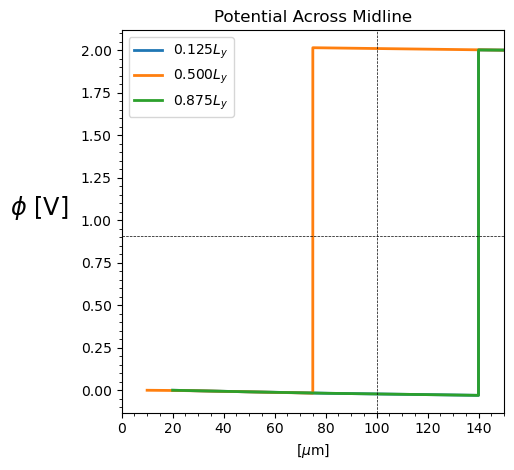

In [15]:
bb_trees = bb_tree(domain, domain.topology.dim)
n_points = 10000
tol = 1e-14  # Avoid hitting the outside of the domain
x = np.linspace(tol, LX - tol, n_points)

y_pos = [0.125, 0.5, 0.875]
points = np.zeros((3, n_points))
points[0] = x
fig, ax = plt.subplots()
for pos in y_pos:
    y = np.ones(n_points) * pos * LY  # midline
    points[1] = y
    u_values = []
    cells = []
    points_on_proc = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = compute_collisions_points(bb_trees, points.T)
    # Choose one of the cells that contains the point
    colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    u_values = u.eval(points_on_proc, cells)

    ax.plot(points_on_proc[:, 0] / micron, u_values, linewidth=2, label=f'{pos:.3f}' + r'$L_y$')
ax.axhline(y=10/11, color='k', linestyle='--', linewidth=0.5)
ax.axvline(x=100, color='k', linestyle='--', linewidth=0.5)
# ax.grid(True)
ax.legend()
ax.set_xlim([0, LX / micron])
# ax.set_ylim([0, voltage])
ax.set_ylabel(r'$\phi$ [V]', rotation=0, labelpad=30, fontsize='xx-large')
ax.set_xlabel(r'[$\mu$m]')
ax.set_title('Potential Across Midline')
ax.set_box_aspect(1)
ax.minorticks_on();
plt.tight_layout()
plt.show()

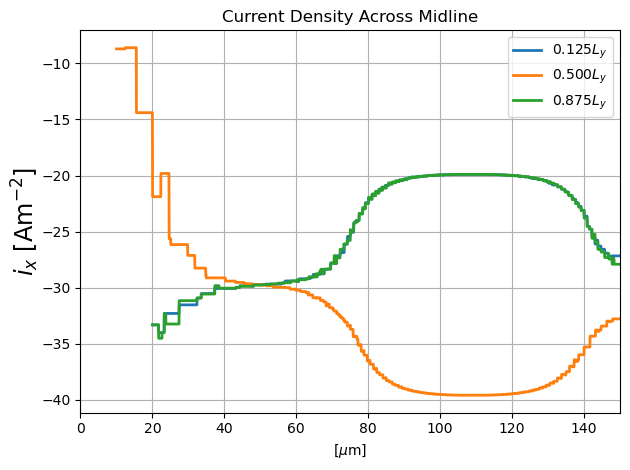

In [16]:
bb_trees = bb_tree(domain, domain.topology.dim)
x = np.linspace(tol, LX - tol, n_points)
points = np.zeros((3, n_points))
points[0] = x
fig, ax = plt.subplots()
for pos in y_pos:
    y = np.ones(n_points) * pos * LY  # midline
    points[1] = y
    u_values = []
    cells = []
    points_on_proc = []
    # Find cells whose bounding-box collide with the the points
    cell_candidates = compute_collisions_points(bb_trees, points.T)
    # Choose one of the cells that contains the point
    colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    points_on_proc = np.array(points_on_proc, dtype=np.float64)
    current_values = current_h.eval(points_on_proc, cells)
    
    ax.plot(points_on_proc[:, 0] / micron, -current_values[:,0], label=f'{pos:.3f}' + r'$L_y$', linewidth=2)
ax.grid(True)
ax.legend()
ax.set_xlim([0, LX / micron])
# ax.set_ylim([0, voltage])
ax.set_ylabel(r'$i_x$ [Am$^{-2}$]', rotation=90, labelpad=0, fontsize='xx-large')
ax.set_xlabel(r'[$\mu$m]')
ax.set_title('Current Density Across Midline')
plt.tight_layout()
plt.show()

In [17]:
a = c * q * dx_r + dt * ufl.inner(D * ufl.grad(c), ufl.grad(q)) * dx_r
L = (
    (c_n + dt * fc) * q * dx_r 
    + dt * ufl.inner(gc, q) * ds_r(markers.insulated_positive_am) 
    + dt * ufl.inner(gc, q) * ds_r(markers.right)
    - dt * ufl.inner(kappa_pos_am*ufl.grad(potential) / 96485, nc) * q * ds_r(markers.electrolyte_v_positive_am)
)



c_vtx = VTXWriter(comm, concentration_resultsfile, [ch], engine="BP4")
c_vtx.write(0.0)
c_avg = fem.assemble_scalar(fem.form(c_n * dx_r)) / fem.assemble_scalar(fem.form(1 * dx_r))
print(f"time: {t}s, average concentration: {c_avg}")
while t < T:
    t += dt

    problem = petsc.NonlinearProblem(F, u)
    solver = petsc_nls.NewtonSolver(comm, problem)
    solver.convergence_criterion = "residual"
    solver.maximum_iterations = 100
    
    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "gmres"
    opts[f"{option_prefix}pc_type"] = "lu"
    opts["pc_factor_mat_solver_type"] = "superlu_dist"
    ksp.setFromOptions()
    n_iters, converged = solver.solve(u)

    potential.interpolate(u, nmm_interpolation_data=u1_2_u2_nmm_data)
    potential.x.scatter_forward()

    # concentration
    bilinear_form = fem.form(a)
    linear_form = fem.form(L)
    
    A = petsc.assemble_matrix(bilinear_form, bcs=[])
    A.assemble()
    b = fem.petsc.create_vector(linear_form)
    
    solver = PETSc.KSP().create(comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.GMRES)
    solver.getPC().setType(PETSc.PC.Type.LU)
    solver.setTolerances(atol=1e-6, rtol=1e-6)

    A = fem.petsc.assemble_matrix(bilinear_form, bcs=[])
    A.assemble()
    solver.setOperators(A)

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    fem.petsc.assemble_vector(b, linear_form)

    # Apply Dirichlet boundary condition to the vector
    fem.petsc.apply_lifting(b, [bilinear_form], [[]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, [])

    # Solve linear problem
    solver.solve(b, ch.vector)
    ch.x.scatter_forward()
    c_avg = fem.assemble_scalar(fem.form(ch * dx_r)) / fem.assemble_scalar(fem.form(1 * dx_r))
    print(f"time: {t}s, average concentration: {c_avg}")

    # Update solution at previous time step (c_n)
    # if np.any(ch.x.array < 0):
    #     print(f"Lithium depletion at {t:.2e} seconds")
    #     break
    if np.any(ch.x.array == np.inf):
        print(f"diverged at {t:.2e} seconds")
        break
    c_n.x.array[:] = ch.x.array
    cp.interpolate(ch, nmm_interpolation_data=u2_2_u1_nmm_data)
    cp.x.scatter_forward()
    c_vtx.write(t)
c_vtx.close()

time: 0s, average concentration: 1000.0000000000031
time: 0.0001s, average concentration: 1032.570736323912
time: 0.0002s, average concentration: 1062.8216226473075
time: 0.00030000000000000003s, average concentration: 1091.9580660496547
time: 0.0004s, average concentration: 1120.3013259644417
time: 0.0005s, average concentration: 1147.9989526766608
time: 0.0006000000000000001s, average concentration: 1175.1299850597627
time: 0.0007000000000000001s, average concentration: 1201.7368883686552
time: 0.0008000000000000001s, average concentration: 1227.8369787376316
time: 0.0009000000000000002s, average concentration: 1253.4226382995773


RuntimeError: Newton solver did not converge because maximum number of iterations reached

In [ ]:
ocv(13396.541762958072), ocv(13127.255764440137), ocv(12844.928684878274)